# Temporal Convolutional Network
In this notebook, we show an example of how TCNs can be used with darts.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

## Air passengers dataset

In [3]:
# Read data:
ts = AirPassengersDataset().load()
scaler = Scaler()
ts = scaler.fit_transform(ts)  # scale the whole time series not caring about train/val split...

# We'll use the month as a covariate
month_series = datetime_attribute_timeseries(ts, attribute='month', one_hot=True)
scaler_month = Scaler()
month_series = scaler_month.fit_transform(month_series)

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp('19580801'))
train_month, val_month = month_series.split_after(pd.Timestamp('19580801'))

In the following cell, we will build a `TCNModel`. Later, when we train it, the model will initiate its internal input width to 2, as we have one dimension for the time series and another dimension for the covariate month time series (this will be transparent to us, though).
Additionally, since we later want to simulate a historic forecast 6 months into the future, we have to make sure the `output_chunk_length` parameter of our `TCNModel` instance has a value of at least 6. 

If we don't specify the `num_layers` parameter, it will be chosen automatically to be the minimum number to ensure full history coverage for every entry in the output, i.e. every output will be dependent on the whole input.

In [4]:
model_air = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12, 
    n_epochs=500, 
    dropout=0.1, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [7]:
model_air.fit(series=train, 
              past_covariates=train_month, 
              val_series=val, 
              val_past_covariates=val_month, 
              verbose=True)

[2021-08-01 13:13:00,823] INFO | darts.models.torch_forecasting_model | Train dataset contains 92 samples.
[2021-08-01 13:13:00,823] INFO | darts.models.torch_forecasting_model | Train dataset contains 92 samples.
[2021-08-01 13:13:00,829] INFO | darts.models.tcn_model | Number of layers chosen: 2
[2021-08-01 13:13:00,829] INFO | darts.models.tcn_model | Number of layers chosen: 2
[2021-08-01 13:13:00,837] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-01 13:13:00,837] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/500 [00:00<?, ?it/s]

Let's see what we get for a 6-months prediction:

  0%|          | 0/39 [00:00<?, ?it/s]

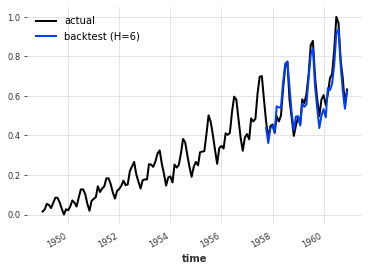

In [8]:
backtest = model_air.historical_forecasts(series=ts,
                                          past_covariates=month_series,
                                          start=0.7,
                                          forecast_horizon=6,
                                          retrain=False,
                                          verbose=True)

ts.plot(label='actual')
backtest.plot(label='backtest (H=6)')
plt.legend();

## Monthly sunspots
Let's try using the `TCNModel` on a more complex and much bigger dataset.

In [9]:
series_sunspot = SunspotsDataset().load()
scaler = Scaler()
series_sp_transformed = scaler.fit_transform(series_sunspot)

# series_sunspot = series_sunspot.add_datetime_attribute('month', True)
train_sp_transformed, val_sp_transformed = series_sp_transformed.split_after(pd.Timestamp('19401001'))

In [10]:
model_sun = TCNModel(
    input_chunk_length=250,
    output_chunk_length=36,
    n_epochs=100, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1,
    random_state=0
)

In [11]:
model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

[2021-08-01 13:13:39,307] INFO | darts.models.torch_forecasting_model | Train dataset contains 2017 samples.
[2021-08-01 13:13:39,307] INFO | darts.models.torch_forecasting_model | Train dataset contains 2017 samples.
[2021-08-01 13:13:39,310] INFO | darts.models.tcn_model | Number of layers chosen: 6
[2021-08-01 13:13:39,310] INFO | darts.models.tcn_model | Number of layers chosen: 6
[2021-08-01 13:13:39,314] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-01 13:13:39,314] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

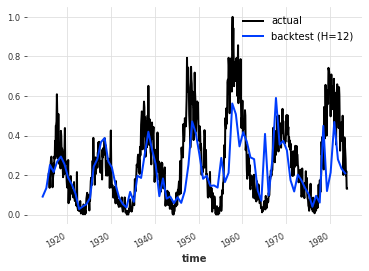

In [12]:
backtest_sp = model_sun.historical_forecasts(series_sp_transformed,
                                             start=0.7,
                                             forecast_horizon=12,
                                             stride=10,
                                             retrain=False,
                                             verbose=True)

series_sp_transformed[2000:].plot(label='actual')
backtest_sp.plot(label='backtest (H=12)')
plt.legend();

## Daily energy production

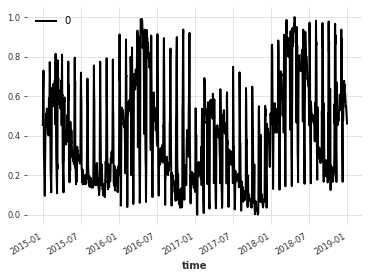

In [13]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
series_en = fill_missing_values(TimeSeries.from_dataframe(df3_day_avg, 'time', ['generation hydro run-of-river and poundage']), 'auto')

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(pd.Timestamp('20170901'))

# add the day as a covariate
day_series = datetime_attribute_timeseries(series_en_transformed, attribute='day', one_hot=True)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp('20170901'))

series_en_transformed.plot()

In [14]:
model_en = TCNModel(
    input_chunk_length=365,
    output_chunk_length=7,
    n_epochs=50,
    dropout=0.2, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=8,
    nr_epochs_val_period=1,
    random_state=0
)

In [15]:
model_en.fit(series=train_en_transformed, 
             past_covariates=train_day,
             verbose=True)

[2021-08-01 13:17:10,560] INFO | darts.models.torch_forecasting_model | Train dataset contains 605 samples.
[2021-08-01 13:17:10,560] INFO | darts.models.torch_forecasting_model | Train dataset contains 605 samples.
[2021-08-01 13:17:10,563] INFO | darts.models.tcn_model | Number of layers chosen: 6
[2021-08-01 13:17:10,563] INFO | darts.models.tcn_model | Number of layers chosen: 6
[2021-08-01 13:17:10,570] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-01 13:17:10,570] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

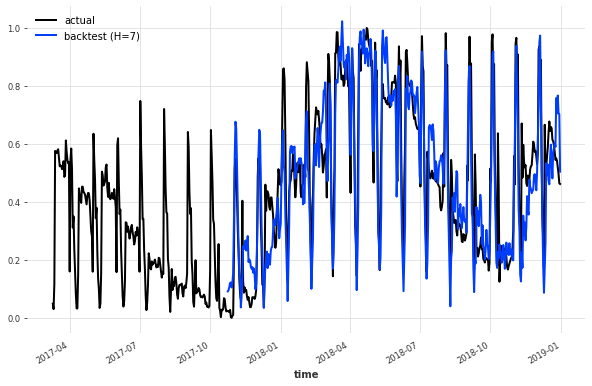

In [16]:
backtest_en = model_en.historical_forecasts(series=series_en_transformed,
                                            past_covariates=day_series,
                                            start=0.7,
                                            forecast_horizon=7,
                                            stride=1,
                                            retrain=False,
                                            verbose=True)

plt.figure(figsize=(10,6))
series_en_transformed[800:].plot(label='actual')
backtest_en.plot(label='backtest (H=7)')
plt.legend();